In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
from NCP.utils import frnp, FastTensorDataLoader
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from NCP.nn.callbacks import LitProgressBar

#from NCP.cde_fork.density_estimator import NormalizingFlowEstimator

import itertools

from NCP.examples.tools.plot_utils import setup_plots
from NCP.examples.tools.data_gen import gen_bimodal, get_conditional_bimodal_cdf, get_conditional_bimodal_pdf
from NCP.examples.tools.lincde import lincde
setup_plots()

# TODO: add them to a utils folder
class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')


np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Generating bimodal data as presented in LinCDE (Gao and Hastie). X are 20 dimensional, but only the first 3 dimensions impact Y. 
- the first dimension gives the mean, 
- the second the modality (bi or uni modal) 
- the third the asymetry.

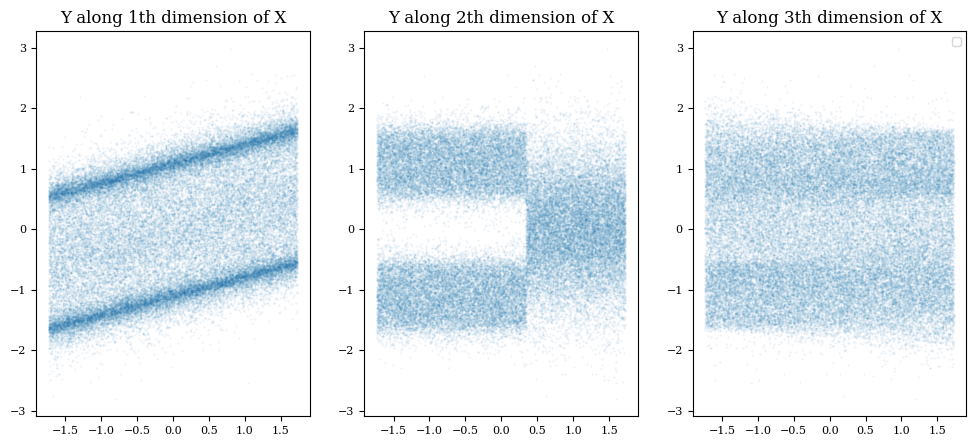

In [3]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_bimodal(0.5, 30, N_train=Ntrain, N_val=Nval, N_test=Ntest)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.scatter(X_train[:,i], Y_train, alpha=0.1, s=0.2)
    ax.set_title(f'Y along {i+1}th dimension of X')
    if i == 0 :
        plt.legend(['train', 'val', 'test'])
plt.show()

# 1. training NCP

Seed set to 0
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gregoirepacreau/anaconda3/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


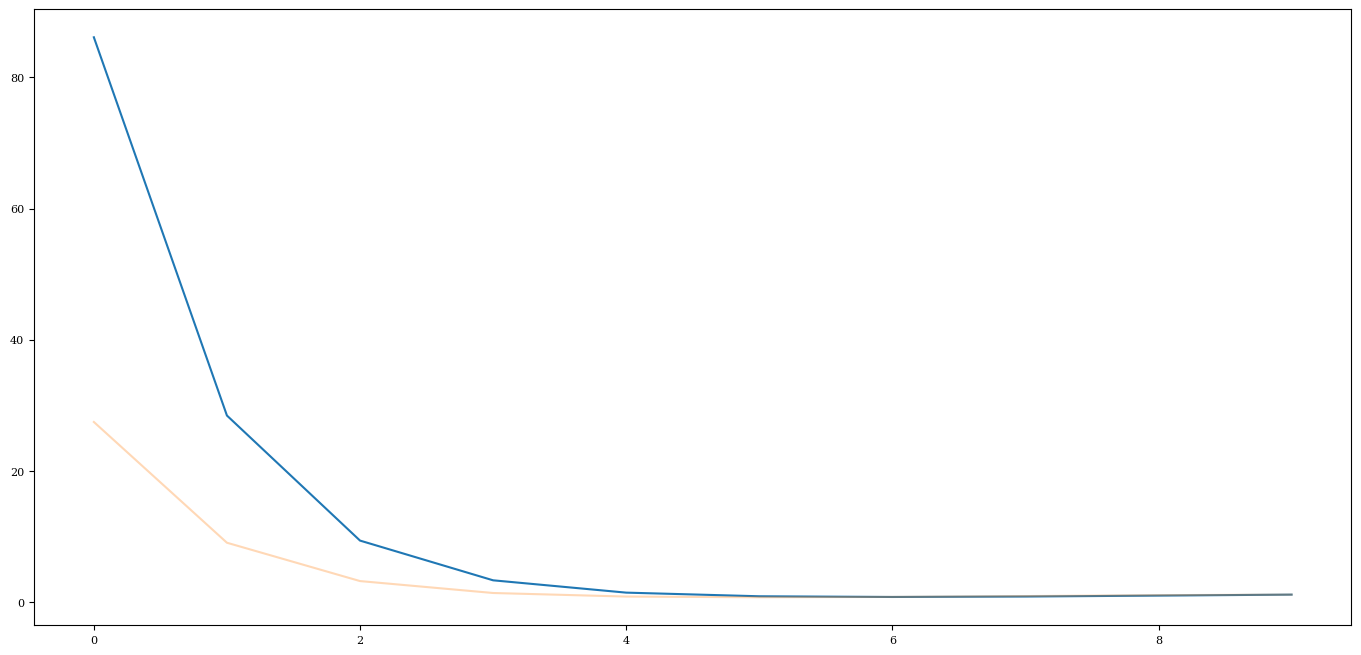

In [4]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e1)
output_shape = 100

MLP_kwargs_U = {
    'input_shape': X_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

MLP_kwargs_V = {
    'input_shape': Y_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)


early_stop = EarlyStopping(monitor="val_loss", patience=100, mode="min")
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="val_loss", mode="min")

train_dl = FastTensorDataLoader(X_train_torch, Y_train_torch, batch_size=len(X_train_torch), shuffle=False)
val_dl = FastTensorDataLoader(X_val_torch, Y_val_torch, batch_size=len(X_val_torch), shuffle=False)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'enable_model_summary': False,
    }, callbacks=[early_stop, checkpoint_callback])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

# recover best model during training
best_model_dict = torch.load(checkpoint_callback.best_model_path)
restore_buffers_shape(reg, best_model_dict['state_dict'])
NCP_module.load_state_dict(best_model_dict['state_dict'])
best_model = NCP_module.model

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

# 2. Training Normalising Flows

In [ ]:
# give the same capacity as the NCP network
density_estimator_kwargs = {'name': 'nflow', 'hidden_sizes': (32, 32), 'hidden_nonlinearity': tf.tanh}

model = NormalizingFlowEstimator(**density_estimator_kwargs)
model.fit(X_train, Y_train, eval_set=(X_val, Y_val), verbose=False)

In [40]:
p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=1000, retstep=True)

cdf = lincde(X_train[:50], Y_train[:50], [X_val[0]], y_discr)

/Users/gregoirepacreau/Documents/NCP/NCP/examples
[1] "boosting stopped after trees:"
[1] 34
        [,1]       [,2]       [,3]       [,4]      [,5]       [,6]       [,7]
2 0.01737506 0.02049269 0.02393169 0.02767257 0.0316621 0.03561686 0.03902299
        [,8]       [,9]      [,10]    [,11]      [,12]      [,13]      [,14]
2 0.04126205 0.04195146 0.04108605 0.038841 0.03560617 0.03195286 0.02835299
       [,15]      [,16]      [,17]     [,18]      [,19]      [,20]      [,21]
2 0.02511706 0.02239144 0.02024055 0.0186849 0.01767656 0.01716466 0.01713277
       [,22]      [,23]     [,24]      [,25]      [,26]      [,27]      [,28]
2 0.01754765 0.01835153 0.0194978 0.02091085 0.02243396 0.02385247 0.02493906
       [,29]      [,30]      [,31]      [,32]      [,33]      [,34]     [,35]
2 0.02560336 0.02581165 0.02556107 0.02492802 0.02402904 0.02297631 0.0218206
       [,36]      [,37]      [,38]      [,39]      [,40]
2 0.02056062 0.01919933 0.01775306 0.01625407 0.01473508


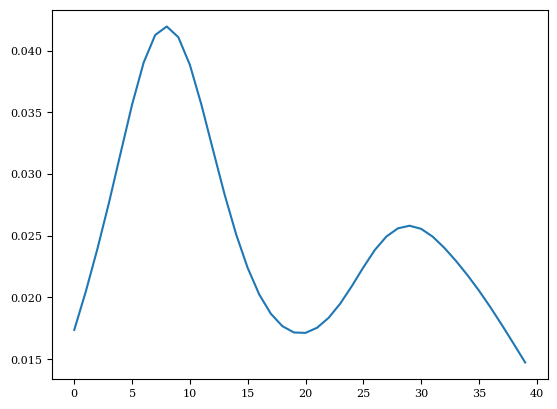

In [43]:
plt.plot(pdf.T)

# 4. Results

result:
- KL: nan
- Hellinger: nan
result:
- KL: nan
- Hellinger: nan
result:
- KL: nan
- Hellinger: nan
result:
- KL: nan
- Hellinger: nan


/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
/Users/gregoirepacreau/

result:
- KL: nan
- Hellinger: nan
result:
- KL: nan
- Hellinger: nan
result:
- KL: nan
- Hellinger: nan
result:
- KL: nan
- Hellinger: nan


/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:25: RuntimeWarning: divide by zero encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)
/Users/gregoirepacreau

result:
- KL: nan
- Hellinger: nan


/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:25: RuntimeWarning: invalid value encountered in log
  return np.sum(x_hist * (np.log(x_hist)-np.log(y_hist)))
/Users/gregoirepacreau/Documents/NCP/NCP/metrics.py:20: RuntimeWarning: invalid value encountered in sqrt
  return np.sum((np.sqrt(x_hist) - np.sqrt(y_hist))**2)


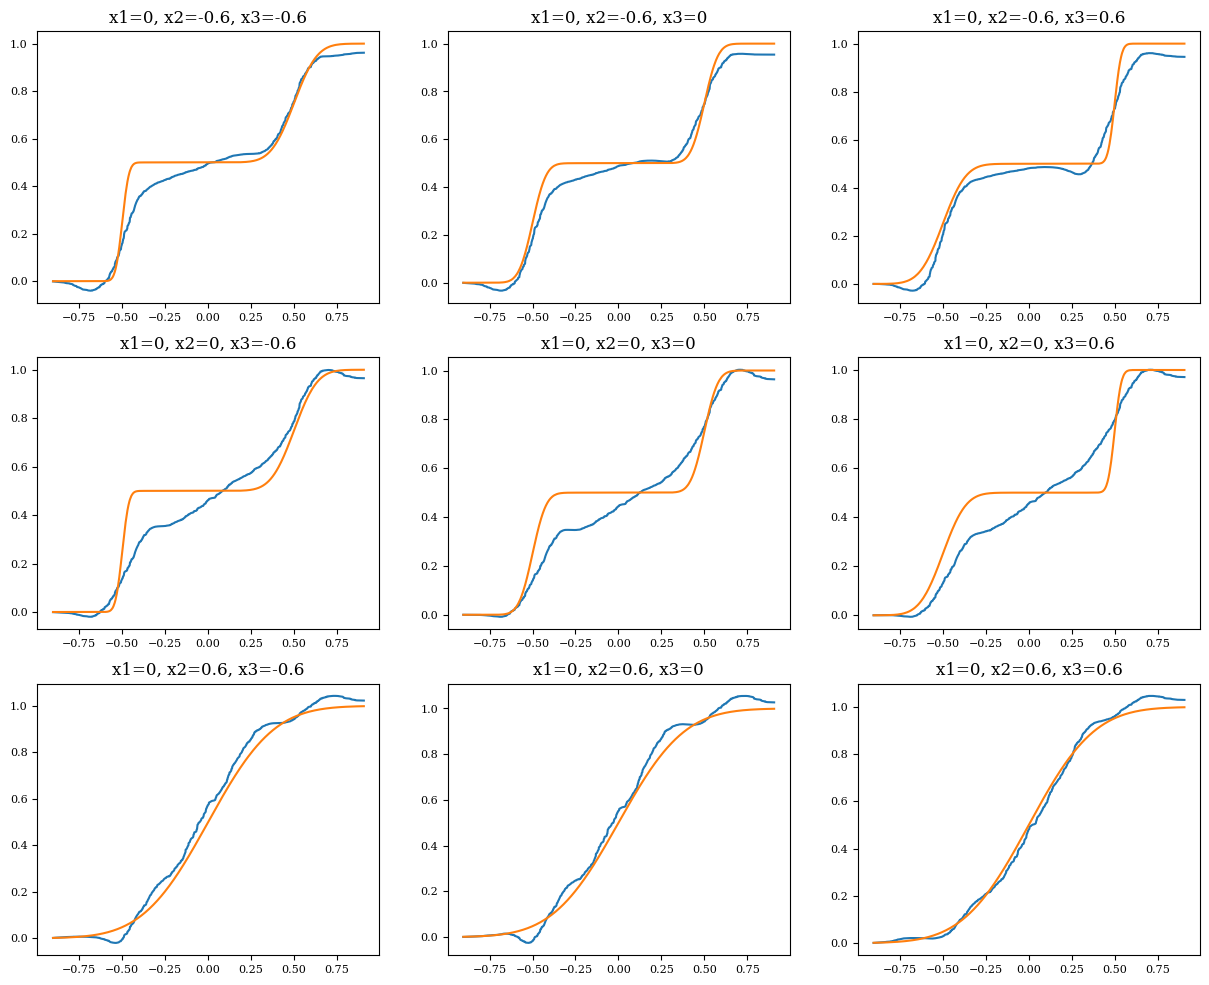

In [9]:
# todo: plot different cdfs, replicate plots from linCDE

x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x]))
    fys, cdf_pred = best_model.cdf(x_scaled, Y_val_torch, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = get_conditional_bimodal_cdf(x, fys)

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')
    print('result:')
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')

plt.show()

Should we verify that the other dimensions are independent?

NameError: name 'best_model' is not defined

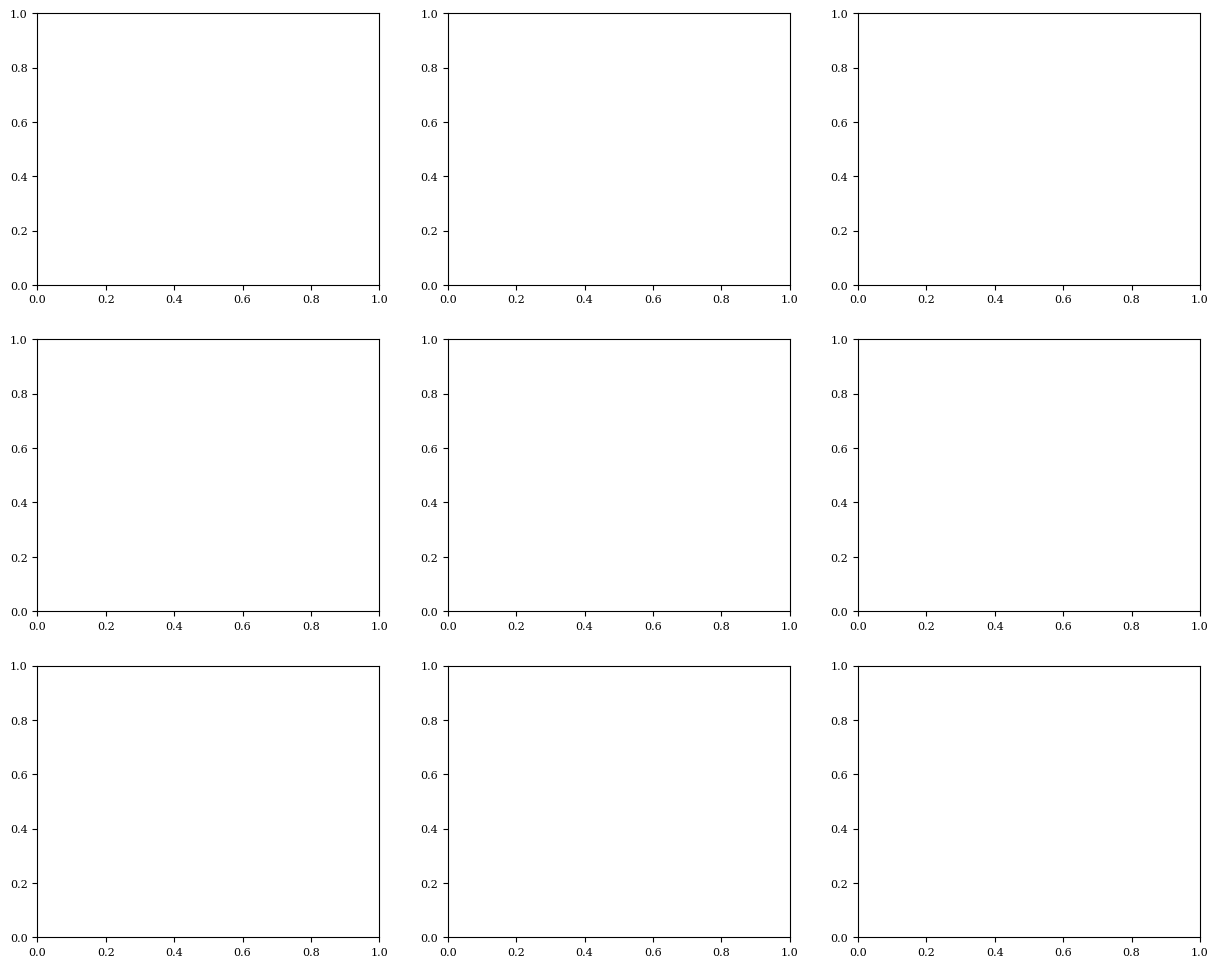

In [17]:
from sklearn.neighbors import KernelDensity
from NCP.utils import tonp

x1 = [0] # mean
x3 = [-0.6, 0, 0.6] # asymetry
x2 = [-0.6, 0, 0.6] # modality

xs = itertools.product(x1, x2, x3)

p1, p99 = np.percentile(Y_train, [1, 99])
y_discr, step = np.linspace(p1, p99, num=1000, retstep=True)

fig, ax = plt.subplots(nrows=(len(x1)*len(x2)), ncols=len(x3), figsize=(15,12))
axes = ax.flatten()

y_discr_torch = torch.Tensor(y_discr.reshape((-1, 1)))

k_pdf = KernelDensity(kernel="gaussian", bandwidth=1.).fit(Y_train)
marginal = lambda x : torch.Tensor(np.exp(k_pdf.score_samples(x.reshape(-1, 1))))

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = xscaler.transform([x])
    x_scaled_torch = frnp(x_scaled)
    fys, pdf_pred = best_model.pdf(x_scaled_torch, y_discr_torch, p_y=marginal, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    lincde_pdf = cdf = lincde(X_train, Y_train, [x], y_discr)

    true_pdf = get_conditional_bimodal_pdf(x, y_discr)

    axes[i].plot(fys, pdf_pred)
    axes[i].plot(fys, lincde_pdf)
    axes[i].plot(fys, true_pdf)
    axes[i].set_title(f'x1={round(xi[0], 3)}, x2={round(xi[1], 3)}, x3={round(xi[2], 3)}')

plt.show()